https://github.com/TrashSure-Team/trashsure-ml-classification-model 

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [34]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [ ]:
# MobileNetV2 Base
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                   include_top=False, weights='imagenet')

# Fine-Tune the Model by adding Fully Connected Layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

# Create the Model
model = create_model()
model.compile(optimizer='Adam',
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

In [11]:
model = tf.keras.models.load_model('TrashSure-model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3

In [13]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 128.0
    return img_array

In [27]:
# img_path = '../sample_data/metal_coke.jpg'
# img_path = '../sample_data/plastic_bottle_partial.jpg'
img_path = '../../trainingData/metal/image_20240922_040431_4.jpg'
# img_path = '../../trainingData/metal/image_20240922_034123_3.jpg'
# img_path = '../../trainingData/plastic/image_20240922_023123_10.jpg'
# img_path = '../../trainingData/plastic/image_20240922_031110_3.jpg'
# img_path = '../trainingData/metalNoLid/image_20240923_024508_1.jpg'
# img_path = '../trainingData/plasticNoLid/image_20240923_023256_1.jpg'

In [28]:
processed_image = preprocess_image(img_path)

In [29]:
# Perform inference
predictions = model.predict(processed_image)

# Retrieve the predicted class
class_indices = {'Glass': 0, 'Medical': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Textiles': 5, 'e-Waste': 6}
predicted_class = max(class_indices, key=lambda x: class_indices[x] == np.argmax(predictions))

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 27ms/step
Predicted Class: e-Waste


Metrics

In [169]:
data_directory = '../trainingData'
categories = ['metalNoLid', 'plasticNoLid']

In [170]:
# Define class indices as per the model's training setup
class_indices = {'Glass': 0, 'Medical': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Textiles': 5, 'e-Waste': 6}

In [171]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    directory=data_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=categories
)

Found 180 images belonging to 2 classes.


In [172]:
# Get the true class indices from the generator
true_labels = test_generator.classes  # True labels from the test generator (0 for metalNoLid, 1 for plasticNoLid)

# Map the test generator class indices to the model's class indices
mapped_true_labels = [class_indices['Metal'] if label == 0 else class_indices['Plastic'] for label in true_labels]

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

6/6 [==============================] - 1s 128ms/step


In [173]:
# Identify unique classes in both true and predicted labels
unique_classes = np.unique(np.concatenate((mapped_true_labels, predicted_labels)))

# Adjust class names to match unique classes present in the results
adjusted_class_labels = [list(class_indices.keys())[list(class_indices.values()).index(cls)] for cls in unique_classes]

In [174]:
# Calculate overall accuracy
accuracy = accuracy_score(mapped_true_labels, predicted_labels)

# Generate confusion matrix including all possible classes
conf_matrix = confusion_matrix(mapped_true_labels, predicted_labels, labels=unique_classes)

# Generate a classification report for the predicted classes
class_report = classification_report(mapped_true_labels, predicted_labels, target_names=adjusted_class_labels)

c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [175]:
# Display the results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.4556
Confusion Matrix:
[[ 0  0  0  0  0]
 [ 0  5 42  2 11]
 [ 0  0  0  0  0]
 [ 1  0 17 77 25]
 [ 0  0  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

       Glass       0.00      0.00      0.00         0
       Metal       1.00      0.08      0.15        60
       Paper       0.00      0.00      0.00         0
     Plastic       0.97      0.64      0.77       120
     e-Waste       0.00      0.00      0.00         0

    accuracy                           0.46       180
   macro avg       0.39      0.15      0.19       180
weighted avg       0.98      0.46      0.57       180



In [176]:
# Custom analysis for all classes
print("\nDetailed Prediction Analysis:")
for true_label, pred_label in zip(mapped_true_labels, predicted_labels):
    true_class = list(class_indices.keys())[list(class_indices.values()).index(true_label)]
    pred_class = list(class_indices.keys())[list(class_indices.values()).index(pred_label)]
    
    if true_label == pred_label:
        print(f"Correct: True {true_class}, Predicted {pred_class}")
    else:
        print(f"Incorrect: True {true_class}, Predicted {pred_class}")

# Count predictions for each class
class_predictions = {class_name: sum(predicted_labels == class_index) 
                     for class_name, class_index in class_indices.items()}

print("\nPredictions per class:")
for class_name, count in class_predictions.items():
    print(f"{class_name}: {count}")


Detailed Prediction Analysis:
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted e-Waste
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Pr

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

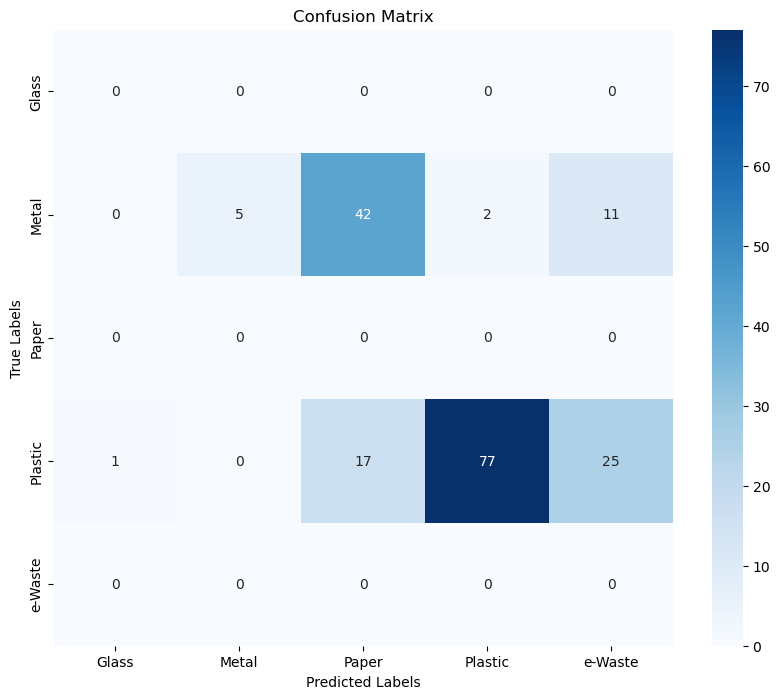

In [178]:
# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=adjusted_class_labels, yticklabels=adjusted_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()